In [1]:
%%bash

pip install getgist
getgist lambdaofgod github_topic_modeling_packages.sh
bash github_topic_modeling_packages.sh

  Fetching https://api.github.com/users/lambdaofgod/gists
  Reading https://gist.githubusercontent.com/lambdaofgod/c32ab43cecce4219a697376f3dda3866/raw/862b57752a5d97d129f9c692a9585904b37cafcf/github_topic_modeling_packages.sh
Overwrite existing github_topic_modeling_packages.sh? (y/n)  [y/N]: Error: invalid input
Overwrite existing github_topic_modeling_packages.sh? (y/n)  [y/N]: 

Aborted!


In [2]:
import re
import tqdm
import requests

import numpy as np

from bs4 import BeautifulSoup
from markdown import markdown


import pandas as pd
from pandas.io.json import json_normalize
from gensim import summarization

from sklearn import decomposition, feature_extraction, manifold
from sklearn.feature_extraction import stop_words
from sklearn import pipeline
 

from mlutil import topic_modeling

import seaborn as sns
import wordcloud

import matplotlib.pyplot as plt
from IPython.display import Markdown, display

/home/kuba/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
plt.style.use('dark_background')

In [4]:
def printmd(string):
    display(Markdown(string))

In [5]:
def get_word_cloud(texts):
  text = ' '.join(texts)
  return wordcloud.WordCloud(max_font_size=40).generate(text)


def show_word_cloud(wc, figure_kwargs={'figsize': (8, 5)}):
  plt.figure(**figure_kwargs)
  plt.imshow(wc)
  plt.axis('off')
  plt.show()

  
def show_word_cloud_from_texts(text_column):
  texts = text_column.fillna('').values
  cloud = get_word_cloud(texts)
  show_word_cloud(cloud)

Put your Github token to `github_auth_key.txt`

You have to do this because, unfortunately, for now there is no way to use GraphQL without authentication.

In [6]:
key = open('github_auth_key.txt', 'r').read().strip()

Note that I barely know GraphQL: I made this query in [Github's API explorer](https://developer.github.com/v4/explorer/)

In [7]:
# An example to get the remaining rate limit using the Github GraphQL API.
headers = {'Authorization': 'token ' + key}


def run_query(query): # A simple function to use requests.post to make the API call. Note the json= section.
    request = requests.post('https://api.github.com/graphql', json={'query': query}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))

        
# The GraphQL query (with a few aditional bits included) itself defined as a multi-line string.       
def get_next_paged_result(result):
  if result is None:
    end_cursor_string = ''
  else:
    end_cursor_string = 'after: "{}"'.format(result['data']['viewer']['starredRepositories']['pageInfo']['endCursor'])
  new_query_string = """{{
    viewer {{
      starredRepositories(first: 100, {}) {{
        pageInfo {{
          startCursor
          hasNextPage
          endCursor
        }}
        nodes {{
          name
          owner {{
            login
          }}
          description
          primaryLanguage {{
            name
          }}
          repositoryTopics(first: 10) {{
            nodes {{
              topic {{
                name
              }}
            }}
          }}
          object(expression: "master:README.md") {{
            ... on Blob {{
              text
            }}
          }}
        }}
      }}
    }}
  }}""".format(end_cursor_string)
  return run_query(new_query_string)

In [8]:
next_result = None
starred_repo_information = []
for __ in tqdm.tqdm(range(5)):
  next_result = get_next_paged_result(next_result)
  starred_repo_information = starred_repo_information + next_result['data']['viewer']['starredRepositories']['nodes']

100%|██████████| 5/5 [00:13<00:00,  2.28s/it]


In [9]:
def get_cleaned_starred_repositories_df(repo_information):
    repo_df = json_normalize(repo_information)
    repo_df.index = repo_df['name']
    repo_df.drop('name', axis=1, inplace=True)
    repo_df['primaryLanguage'] = repo_df['primaryLanguage.name']
    repo_df.drop('primaryLanguage.name', axis=1)
    repo_df['topics'] = repo_df['repositoryTopics.nodes'].apply(lambda recs: [r['topic']['name'] for r in recs])
    repo_df['description'].fillna('', inplace=True)
    repo_df['description_keywords'] = repo_df['description'].apply(summarization.keywords)
    return repo_df

In [10]:
def get_topic_representant_indices(topic_weights, topic_idx, num_representants=5):
    indices = topic_weights[:, topic_idx].argsort()[::-1]
    return indices[:num_representants]


def get_repos_representing_topic(repo_df, topic_weights, topic_idx, num_representants=5):
    return repo_df.iloc[get_topic_representant_indices(topic_weights, topic_idx, num_representants)]

In [11]:
starred_repo_df = get_cleaned_starred_repositories_df(starred_repo_information)

Primary language

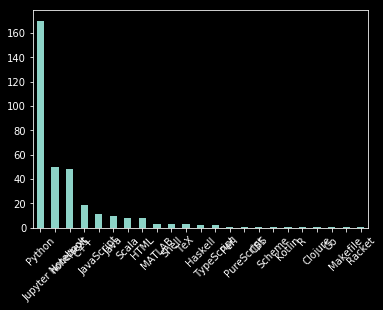

In [12]:
starred_repo_df['primaryLanguage'].fillna('none/text').value_counts().plot.bar(rot=45);

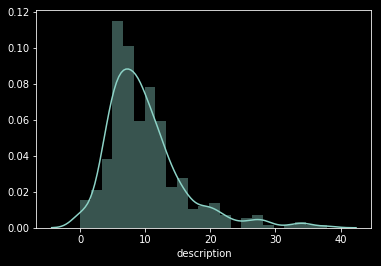

In [13]:
sns.distplot(starred_repo_df['description'].str.split().apply(lambda l: 0 if l is None else len(l)));

Topics word cloud

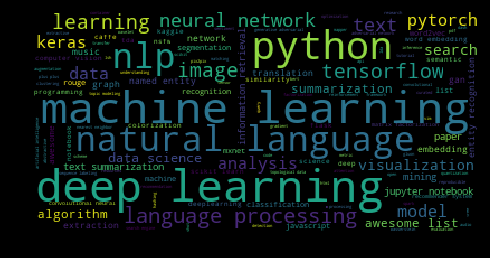

In [14]:
show_word_cloud_from_texts(starred_repo_df['topics'].apply(' '.join))

Descriptions word cloud

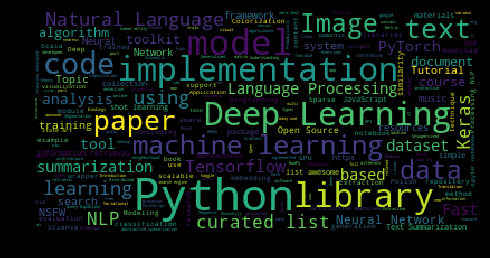

In [15]:
show_word_cloud_from_texts(starred_repo_df['description'])

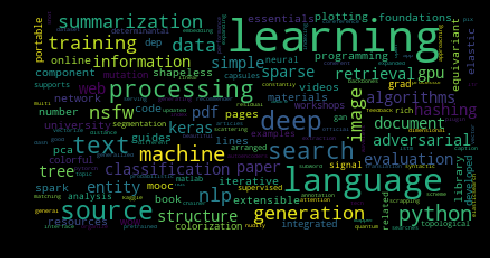

In [18]:
show_word_cloud_from_texts(starred_repo_df['description_keywords'])

## Topic modeling (repo descriptions)

In [19]:
num_topics = 10
nmf = decomposition.NMF(n_components=num_topics)

In [20]:
vectorizer = feature_extraction.text.TfidfVectorizer(
    stop_words=stop_words.ENGLISH_STOP_WORDS,
    ngram_range=(1,2)
)
description_vectors = vectorizer.fit_transform(starred_repo_df['description'])

In [21]:
reduced_description_vectors = nmf.fit_transform(description_vectors)

In [22]:
topic_words = topic_modeling.top_topic_words(nmf, vectorizer.get_feature_names(), 10)

In [23]:
top_words_per_topic = [list(topic_words.iloc[topic].values) for topic in range(num_topics)]
representative_repos = [get_repos_representing_topic(starred_repo_df, reduced_description_vectors, topic)[['description']] for topic in range(num_topics)]

## Topic keywords and most representative repositories

In [24]:
for topic in range(num_topics):
    printmd('## **topic {} keywords:**'.format(topic + 1))
    display(top_words_per_topic[topic])
    printmd('## **repositories representative for {}th topic:**'.format(topic + 1))
    display(representative_repos[topic])
    print()

## **topic 1 keywords:**

['language',
 'natural language',
 'natural',
 'processing',
 'language processing',
 'nlp',
 'processing nlp',
 'course',
 'state art',
 'state']

## **repositories representative for 1th topic:**

,description
name,
flair,A very simple framework for state-of-the-art N...
nlp_course,YSDA course in Natural Language Processing
pytorch-transformers,👾 A library of state-of-the-art pretrained mod...
nlp_tasks,Natural Language Processing Tasks and References
natural-language-processing,"Resources for ""Natural Language Processing"" Co..."


## **topic 2 keywords:**

['deep',
 'deep learning',
 'learning',
 'learning models',
 'hash',
 'learning hash',
 'learning cookbox',
 'cookbox',
 'models',
 'deephash']

## **repositories representative for 2th topic:**

,description
name,
deep_learning_cookbook,Deep Learning Cookbox
deep-learning-model-convertor,The convertor/conversion of deep learning mode...
d2l-en,Dive into Deep Learning: an interactive deep l...
DIGITS,Deep Learning GPU Training System
DeepHash-Papers,Must-read papers on deep learning to hash (Dee...


## **topic 3 keywords:**

['curated',
 'list',
 'curated list',
 'resources',
 'awesome',
 'list awesome',
 'dedicated',
 'resources dedicated',
 'list resources',
 'tutorials']

## **repositories representative for 3th topic:**

,description
name,
awesome-scheme,A curated list of awesome Scheme resources and...
awesome-text-summarization,A curated list of resources dedicated to text ...
awesome-information-retrieval,A curated list of awesome information retrieva...
awesome-spark,A curated list of awesome Apache Spark package...
awesome-rnn,Recurrent Neural Network - A curated list of r...


## **topic 4 keywords:**

['python',
 'implementation',
 'analysis',
 'python implementation',
 'algorithm',
 'data',
 'data analysis',
 'fast',
 'wrapper',
 'detection']

## **repositories representative for 4th topic:**

,description
name,
scikit-tda,Topological Data Analysis for Python🐍
rouge,A full Python Implementation of the ROUGE Metr...
colorization_using_optimization,A python implementation of the Colorization Us...
FISTA,Python implementation of the Fast Iterative Sh...
K-Nearest-Neighbors-with-Dynamic-Time-Warping,Python implementation of KNN and DTW classific...


## **topic 5 keywords:**

['summarization',
 'text',
 'text summarization',
 'extractive',
 'extractive text',
 'summarization using',
 'bert',
 'summarization bert',
 'using',
 'abstractive']

## **repositories representative for 5th topic:**

,description
name,
bert-extractive-summarizer,Easy to use extractive text summarization with...
text-summarizer,Python Framework for Extractive Text Summariza...
keras-text-summarization,Text summarization using seq2seq in Keras
awesome-text-summarization,The guide to tackle with the Text Summarization
WikiHow-Dataset,A Large Scale Text Summarization Dataset


## **topic 6 keywords:**

['machine',
 'machine learning',
 'learning',
 'tools',
 'tools javascript',
 'learning tools',
 'javascript',
 'friendly',
 'learning web',
 'friendly machine']

## **repositories representative for 6th topic:**

,description
name,
ml,Machine learning tools in JavaScript
ml5-library,Friendly machine learning for the web! 🤖
vowpal_wabbit,Vowpal Wabbit is a machine learning system whi...
thinc,🔮 spaCy's Machine Learning library for NLP in ...
few-shot,Repository for few-shot learning machine learn...


## **topic 7 keywords:**

['image',
 'nsfw',
 'neural',
 'keras',
 'colorization',
 'networks',
 'model',
 'collection',
 'nsfw image',
 'image colorization']

## **repositories representative for 7th topic:**

,description
name,
nsfw_data_scraper,Collection of scripts to aggregate image data ...
nsfw_data_source_urls,Collection of NSFW images URLs for the purpose...
colorization,Automatic colorization using deep neural netwo...
UNIT,Unsupervised Image-to-Image Translation
nsfw-v2,NSFW Image Detector with REST interface develo...


## **topic 8 keywords:**

['factorization',
 'machines',
 'factorization machines',
 'library',
 'machines python',
 'aware',
 'aware factorization',
 'field',
 'field aware',
 'fastfm']

## **repositories representative for 8th topic:**

,description
name,
libffm,A Library for Field-aware Factorization Machines
pyFM,Factorization machines in python
fastFM,fastFM: A Library for Factorization Machines
xlearn,"High performance, easy-to-use, and scalable ma..."
nimfa,Nimfa: Nonnegative matrix factorization in Python


## **topic 9 keywords:**

['retrieval',
 'information',
 'information retrieval',
 'open',
 'source',
 'open source',
 'library',
 'source library',
 'library python',
 'retrieval library']

## **repositories representative for 9th topic:**

,description
name,
LIRE,Open source library for content based image re...
irlib,Information Retrieval Library (in Python)
musicinformationretrieval.com,Instructional notebooks on music information r...
anserini,A Lucene toolkit for replicable information re...
go,The Open Source Data Science Masters


## **topic 10 keywords:**

['code',
 'shot',
 'shot learning',
 'zero shot',
 'zero',
 'paper',
 'simple',
 'learning',
 'presented',
 'repository']

## **repositories representative for 10th topic:**

,description
name,
Embarrassingly-simple-ZSL,This repository contains the code for the real...
embarrassingly-simple-zero-shot-learning,This is a started/demo code for Zero-Shot-Lear...
awesome-zero-shot-learning,"A curated list of papers, code and resources p..."
Generalized-Zero-Shot-Learning-via-Aligned-Variational-Autoencoders,This repository has the pytorch implementation...
extremely-simple-one-shot-learning,Extremely simple one-shot learning in Python


## Visualizing repository 2D projection

In [25]:
mds = manifold.MDS()
mds_reduced_vectors = mds.fit_transform(reduced_description_vectors)

In [26]:
representatives = pd.concat(representative_repos)

In [27]:
representative_indices = np.where(starred_repo_df.index.isin(representatives.index))

In [28]:
mds_reduced_representative_vectors = mds_reduced_vectors[representative_indices]

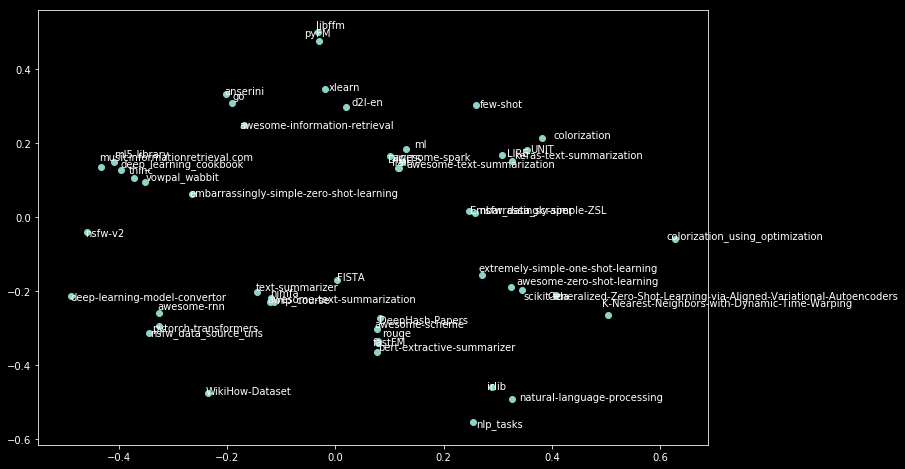

In [29]:
fig, ax = plt.subplots(figsize=(12, 8));

x, y = mds_reduced_representative_vectors[:, 0], mds_reduced_representative_vectors[:, 1]
ax.scatter(x, y)
for i, txt in enumerate(representatives.index):
    ax.annotate(txt, (x[i] + 0.01 * np.random.randn(), y[i] + 0.01 * np.random.randn()))